In [5]:
import sklearn
import math
import numpy as np
import random
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.svm import SVC
from numpy import quantile, where, random
from IPython.display import display, HTML
import time

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
def generate_features(X, Y, window=100):
    """
        Function for generating new data features
        
        Parameters
        ----------
            X : List
                X values
            Y : List
                Y values
            window : int
                count of values (left | right) to take properties of
                
        Returns
        -------
            features : np.array
                matrix with X, Y values and new features
    """
    
    # count of original features
    num_fet = 2
    # count of additional features per window
    num_adv_fet = 4
    # number of windows for each value
    num_windows = 4
    
    features = []
    
    # generate features for the beginning
    for i in range(window):
        new_row = [X[i]]
        
        new_row.append(Y[i])
        
        for j in range(num_adv_fet * num_windows // 2):
            new_row.append(0)
            
        for slc in [Y[i:i + window // 2], Y[i:i + window]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
    
        features.append(new_row)
    
    # generate features for the middle
    for i in range(window, window + len(Y[window:-window])):
        new_row = [X[i]]
        
        new_row.append(Y[i])
        
        for slc in [Y[i - window:i], Y[i - window // 2:i], Y[i:i + window // 2], Y[i:i + window]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
        
        features.append(new_row)
    
    # generate features for the end
    for i in range(window):
        new_row = [X[-window:][i]]
        
        new_row.append(Y[-window:][i])
        
        for slc in [Y[-(2 * window) + i:-window + i], Y[-int(window + window // 2) + i:-window + i]]:
            new_row.append(np.mean(slc))
            new_row.append(np.median(slc))
            new_row.append(np.std(slc))
            new_row.append(np.var(slc))
        
        for j in range(num_adv_fet * num_windows // 2):
            new_row.append(0)
            
        features.append(new_row)
        
    # so that for the first N values there's no N values on the left and for the last N values there's no N values on the right
    # these features will be taken from their neighbours
    features = np.matrix(features)
    features[:window, 2:num_fet + num_adv_fet * num_windows // 2] = features[window:2 * window, 2:num_fet + num_adv_fet * num_windows // 2]
    features[-window:, num_fet + num_adv_fet * num_windows // 2:] = features[-(2 * window):-window, num_fet + num_adv_fet * num_windows // 2:]
        
    return np.array(features)

In [63]:
def fit_svm(fit_data, kernel, gamma, nu, sb1, sb2, sb3):
    """
        Function for fitting svm and printing results
        
        Parameters
        ----------
            fit_data : np.array
                data values
            kernel : string
                kernel for svm model
            gamma : float
                kernel coefficient for svm kernel
            nu : float
                an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
            sb1, sb2, sb3 : plt.AxesSubplot
                subplots for all data, clean data and svm areas
                
        Returns
        -------
            output_values : np.array
                output data
            clean_values : np.array
                clean data
    """
    
    model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)

    pred = model.fit_predict(fit_data)

    anom_index = where(pred==-1)
    values = fit_data[anom_index]

    plt.style.use('dark_background')

    sb1.grid(c='w', alpha=.2, linestyle='-')
    sb1.plot(fit_data[:,0], fit_data[:,1], c='#ed4830')
    sb1.plot(values[:,0], values[:,1], c='b')
    #sb1.set_xlim(-5, 105)
    sb1.set_ylim(0, 25)

    norm_index = where(pred==1)
    selected = fit_data[norm_index]
    sb2.grid(c='w', alpha=.2, linestyle='-')
    sb2.plot(selected[:,0], selected[:, 1], c='#ed4830')
    #sb2.set_ylim(20, 60)
    #print(selected.shape)
    #sb2.set_xlim(-5, 105)
    sb2.set_ylim(0, 25)

    #paint_areas(fit_data, model, sb3)
    
    return values, selected
    #return anom_index, norm_index

In [36]:
def generate_data(data, purge):
    """
        Function for generating middle data to places where values where taken (outputs)
        
        Parameters
        ----------
            data : list
                all Y values
            purge : np.array
                array with indexes of clean data
                
        Returns
        -------
            new_data : list
                new Y values
    """
    
    new_y_start = []
    first_purge_index = int(purge[0])
    first_purge = data[first_purge_index]
    first_raw = data[0]
    
    for i in range(first_purge_index):
        new_y_start.append(first_raw + (first_purge - first_raw) / (first_purge_index - 0) * i)
    
    start = len(new_y_start)
    new_y_end = []
    last_purge_index = int(purge[-1])
    last_purge = data[last_purge_index]
    last_raw = data[-1]
    data_length = len(data)
    
    if start != len(data):
        for i in range(1, data_length - last_purge_index):
            new_y_end.append(last_purge + (last_raw - last_purge) / (data_length - last_purge_index) * i)
        
        end = len(new_y_end)
        purge_iter = 1
        new_y_center = []

        for i in range(len(purge) - 1):
            new_y_center.append(data[int(purge[i])])
            
            new_diap = int(purge[i + 1] - purge[i])
            start_diap = data[int(purge[i])]
            end_diap = data[int(purge[i + 1])]
            
            for j in range(1, new_diap):
                new_y_center.append(start_diap + (end_diap - start_diap) / new_diap * j)
                
        new_y_center.append(data[last_purge_index])
    
    return new_y_start + new_y_center + new_y_end

In [37]:
def upgrade_data(orig_data, new_data, mean_dev):
    """
        Function takes original Y values if it's not far from computional generated data or generated and makes new list
        
        Parameters
        ----------
            orig_data : np.array
                original Y values
            new_data : np.array
                new Y values
            mean_dev : float
                mean deviation in data set
                
        Returns
        -------
            upgraded_data : list
                new combine Y values
    """
    
    upgraded_data = []
    
    for i in range(orig_data.shape[0]):
        if (abs(new_data[i] - orig_data[i]) < mean_dev):
            upgraded_data.append(orig_data[i])
        else:
            upgraded_data.append(new_data[i])
            
    return upgraded_data

In [38]:
df_total = pd.read_csv('C:/Users/exore/Downloads/Telegram Desktop/stirol.csv', sep=';', header=None)
Y = np.array(df_total.iloc[:, -1])
X = np.array(range(len(Y)))
adv_data = generate_features(X, Y, window=500)

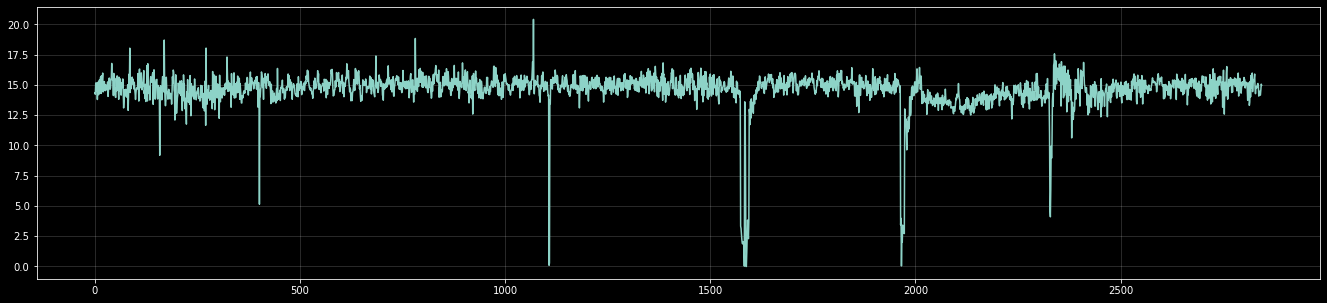

In [39]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(23, 5))
plt.grid(c='w', alpha=.2, linestyle='-')
plt.plot(X, Y)

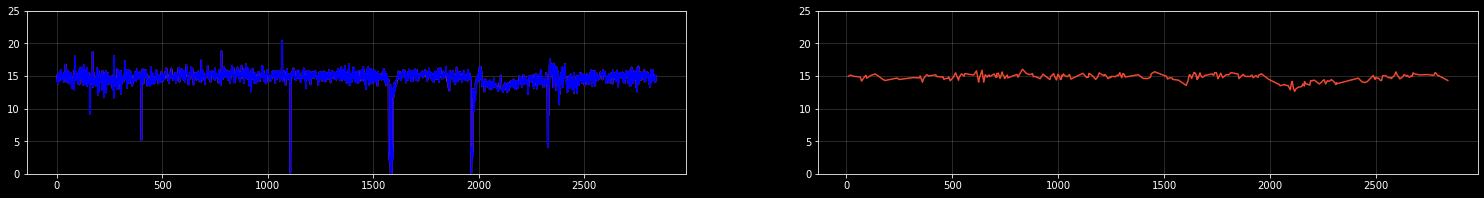

In [64]:
fig = plt.figure(figsize=(26, 3))

sb1 = fig.add_subplot(1, 2, 1)
sb2 = fig.add_subplot(1, 2, 2)
#sb3 = fig.add_subplot(1, 3, 3)
sb3 = None

isekai, purge = fit_svm(fit_data=adv_data, kernel='rbf', gamma=0.1, nu=0.99, sb1=sb1, sb2=sb2, sb3=sb3)
#isekai, purge = fit_svm(fit_data=adv_data, kernel='rbf', gamma=0.002, nu=0.35, sb1=sb1, sb2=sb2, sb3=sb3, vertical_stretch=1.2, horizontal_stretch=0.8)
plt.show()

In [70]:
len(purge)

279

In [65]:
new_data = np.array(adv_data)
new_data[:, 1] = generate_data(Y, np.array(purge)[:,0])

In [66]:
upgraded_data = upgrade_data(adv_data[:, 1], new_data[:, 1], np.std(Y))

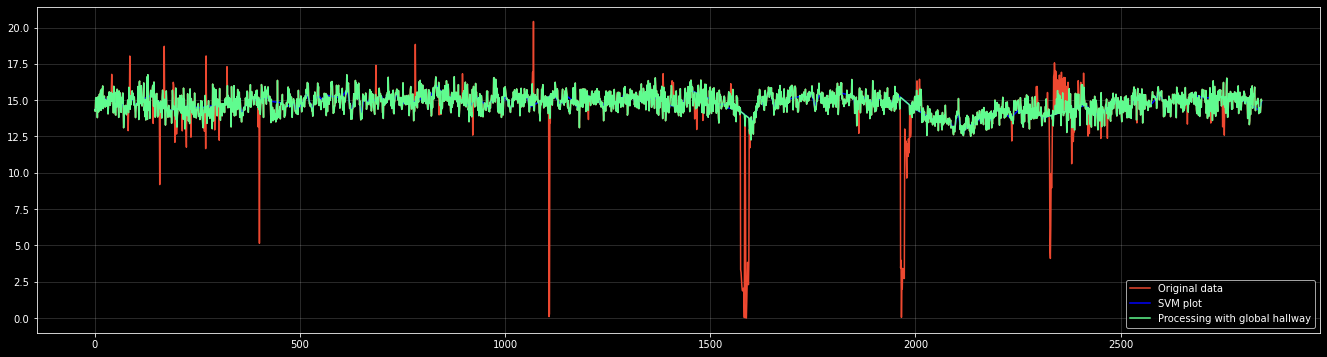

In [67]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(23, 6))

sb1 = fig.add_subplot(1, 1, 1)
#sb2 = fig.add_subplot(1, 3, 2)
#sb3 = fig.add_subplot(1, 3, 3)

sb1.plot(new_data[:, 0], adv_data[:, 1], c='#ed4830')
sb1.plot(new_data[:, 0], new_data[:, 1], c='b')
sb1.plot(new_data[:, 0], upgraded_data, c='#60fc8f')
plt.grid(c='w', alpha = .2, linestyle = '-')
plt.legend(["Original data", "SVM plot", "Processing with global hallway"], loc="lower right")
#sb1.set_ylim(470, 630)
#sb2.set_ylim(470, 630)
#sb3.set_ylim(470, 630)

In [20]:
t1 = time.time()
isekai, purge = fit_svm(fit=adv_data, dots=adv_data, kernel='rbf', gamma=0.1, nu=0.99, sb1=sb1, sb2=sb2, sb3=sb3, ext=1, vert=1, horiz=1)
new_data = np.array(adv_data)
new_data[:, 1] = generate_data(Y, np.array(purge)[:,0])
upgraded_data = upgrade_data(adv_data[:, 1], new_data[:, 1], np.std(Y))
print(time.time() - t1)

1.8610661029815674


In [53]:
df_total = pd.read_csv('C:/Users/exore/Downloads/Telegram Desktop/stirol.csv', sep=';', header=None)

In [54]:
time_array = []

In [56]:
for i in range(44):
    Y = np.array(df_total.iloc[:, i])
    X = np.array(range(len(Y)))
    adv_data = generate_features(X, Y, window=500)
    
    t1 = time.time()
    isekai, purge = fit_svm(fit=adv_data, dots=adv_data, kernel='rbf', gamma=0.1, nu=0.99, sb1=sb1, sb2=sb2, sb3=sb3, ext=1, vert=1, horiz=1)
    new_data = np.array(adv_data)
    new_data[:, 1] = generate_data(Y, np.array(purge)[:,0])
    upgraded_data = upgrade_data(adv_data[:, 1], new_data[:, 1], np.std(Y))
    print(i)
    time_array.append(time.time() - t1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [57]:
time_array = np.array(time_array)
time_array.var(), time_array.mean(), np.median(time_array), np.std(time_array)

(0.02960092152135876,
 1.8847778060219504,
 1.8042219877243042,
 0.17204918343705894)